## EDA

In [1]:
import torch
import transformers
from ast import literal_eval
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM, SFTConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import Dataset
import json
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import evaluate
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from peft import AutoPeftModelForCausalLM, LoraConfig

pd.set_option('display.max_columns', None)

In [2]:
# 난수 고정
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

set_seed(42) # magic number :)

### Load Data

In [3]:
# Load the train dataset
# TODO Train Data 경로 입력
dataset = pd.read_csv('../data/train.csv') 

# Flatten the JSON dataset
records = []
for _, row in dataset.iterrows():
    problems = literal_eval(row['problems'])
    record = {
        'id': row['id'],
        'paragraph': row['paragraph'],
        'question': problems['question'],
        'choices': problems['choices'],
        'answer': problems.get('answer', None),
        "question_plus": problems.get('question_plus', None),
    }
    # Include 'question_plus' if it exists
    if 'question_plus' in problems:
        record['question_plus'] = problems['question_plus']
    records.append(record)
        
# Convert to DataFrame
df = pd.DataFrame(records)

In [4]:
df.head()

,id,paragraph,question,choices,answer,question_plus
0,generation-for-nlp-426,"(가)은/는 의병계열과 애국계몽 운동 계열의 비밀결사가 모여 결성된 조직으로, 총사...",(가)에 대한 설명으로 옳지 않은 것은?,"[고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 ...",1,None
1,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,(가) 지역에 대한 설명으로 옳은 것은?,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...",4,None
2,generation-for-nlp-428,이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다....,밑줄 친 ‘그’에 대한 설명으로 옳은 것은?,"[살수에서 수의 군대를 물리쳤다 ., 김춘추 의 신라 왕위 계승을 지원하였다 ., ...",2,None
3,generation-for-nlp-429,"선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가...",(가) 인물이 추진한 정책으로 옳지 않은 것은?,"[사창제를 실시하였다 ., 대전회통을 편찬하였다 ., 비변사의 기능을 강화하였다 ....",3,None
4,generation-for-nlp-431,(가)의 사신 고제덕 등이 일본에 와서 왕이 보낸 국서를 전하였다. 그 국서에 이르...,(가) 국가에 대한 설명으로 옳은 것은?,"[나 당연합군의 공격으로 멸망하였다 ., 9주 5소경의 지방 행정 구역을 두었다 ....",3,None


### Print missing values

In [5]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
id                  0
paragraph           0
question            0
choices             0
answer              0
question_plus    2030
dtype: int64


### Basic information about the dataset

In [6]:
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2030 entries, 0 to 2029
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             2030 non-null   object
 1   paragraph      2030 non-null   object
 2   question       2030 non-null   object
 3   choices        2030 non-null   object
 4   answer         2030 non-null   int64 
 5   question_plus  0 non-null      object
dtypes: int64(1), object(5)
memory usage: 95.3+ KB


### EDA on 'question' and 'choices'

In [7]:
# Combine 'question' and 'question_plus' if available
df['question_plus'] = df['question_plus'].fillna('')
df['full_question'] = df.apply(lambda x: x['question'] + ' ' + x['question_plus'] if x['question_plus'] else x['question'], axis=1)

# Calculate the length of each question
df['question_length'] = df['full_question'].apply(len)

### Choice Distribution

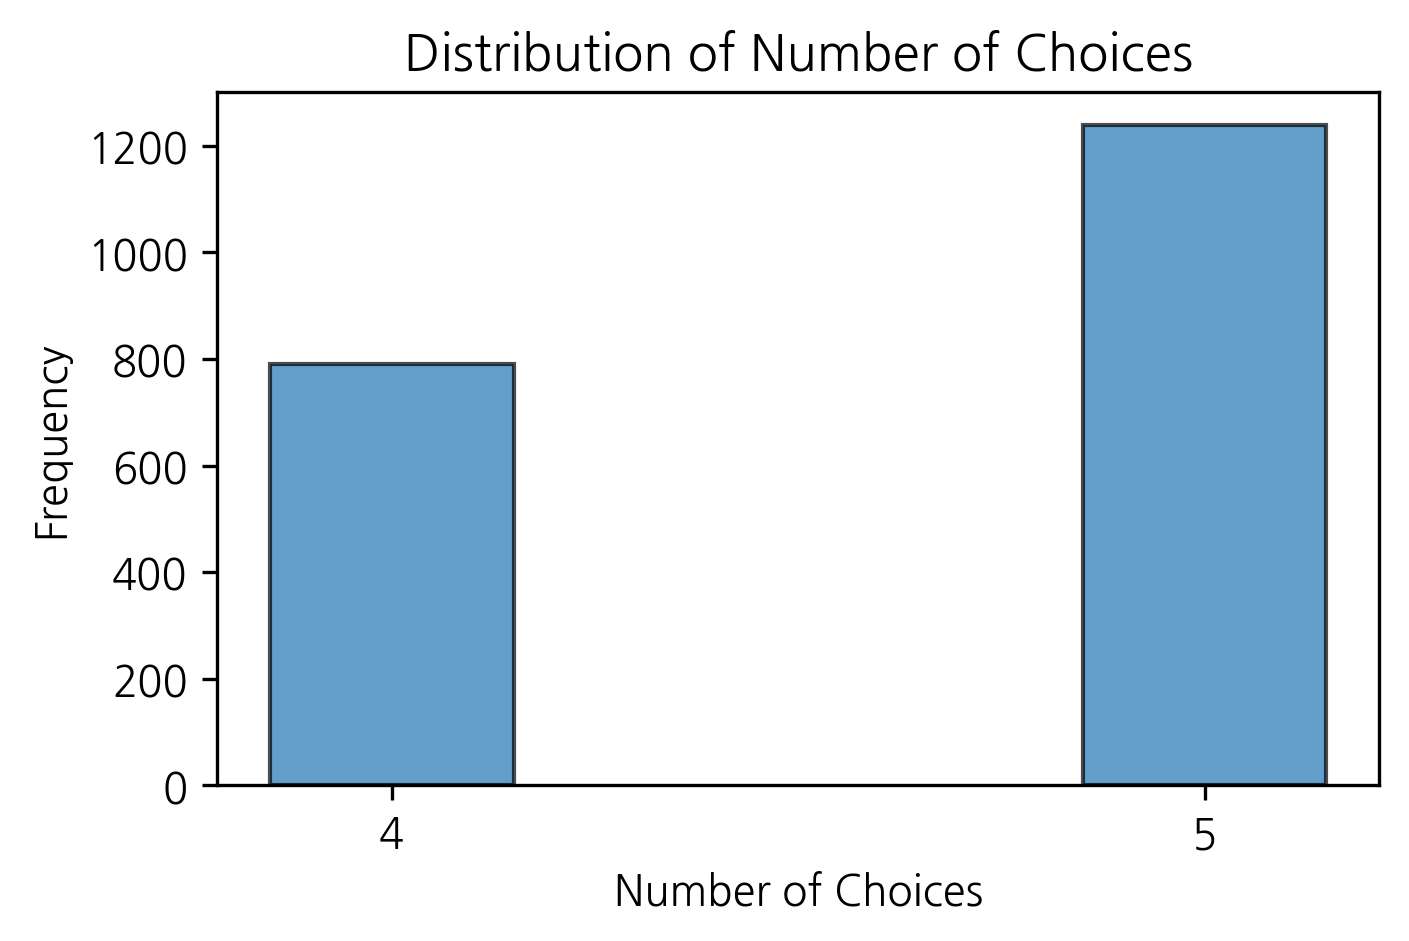

In [8]:
# Calculate the length of each choice list
df['num_choices'] = df['choices'].apply(len)

# Plot the distribution of choices length
plt.figure(figsize=(5, 3))
plt.hist(df['num_choices'], bins=[3.5, 4.5, 5.5], edgecolor='black', alpha=0.7, rwidth=0.3)
plt.title('Distribution of Number of Choices')
plt.xlabel('Number of Choices')
plt.ylabel('Frequency')
plt.xticks([4, 5])
plt.show()

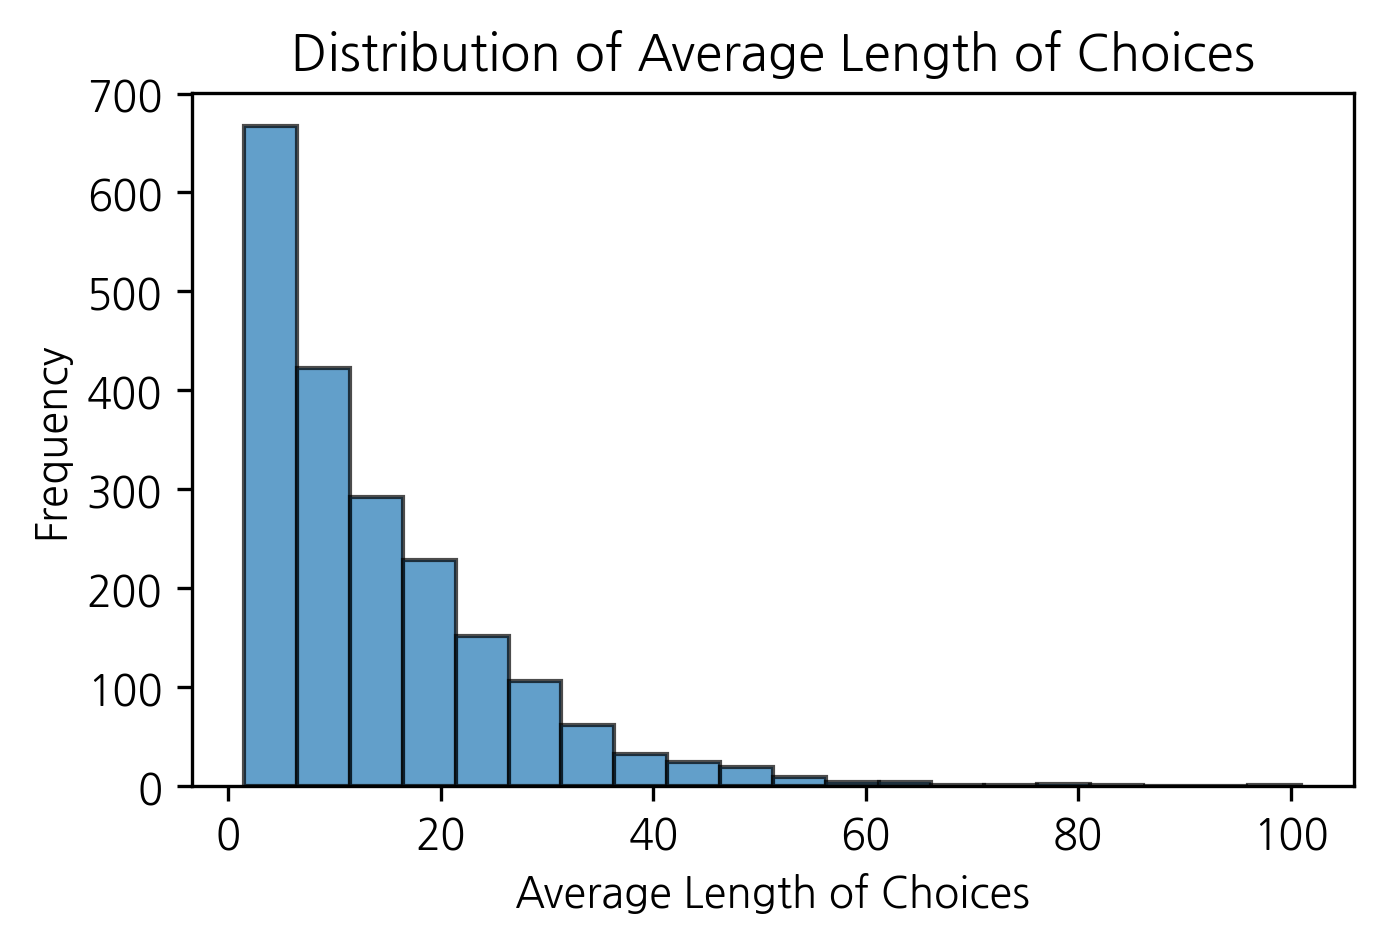

In [9]:
df['avg_len_of_choices'] = df['choices'].apply(lambda x: np.mean([len(choice) for choice in x]))

# Plot the distribution of average length of choices
plt.figure(figsize=(5, 3))
plt.hist(df['avg_len_of_choices'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Average Length of Choices')
plt.xlabel('Average Length of Choices')
plt.ylabel('Frequency')
plt.show()

### Answer Distribution

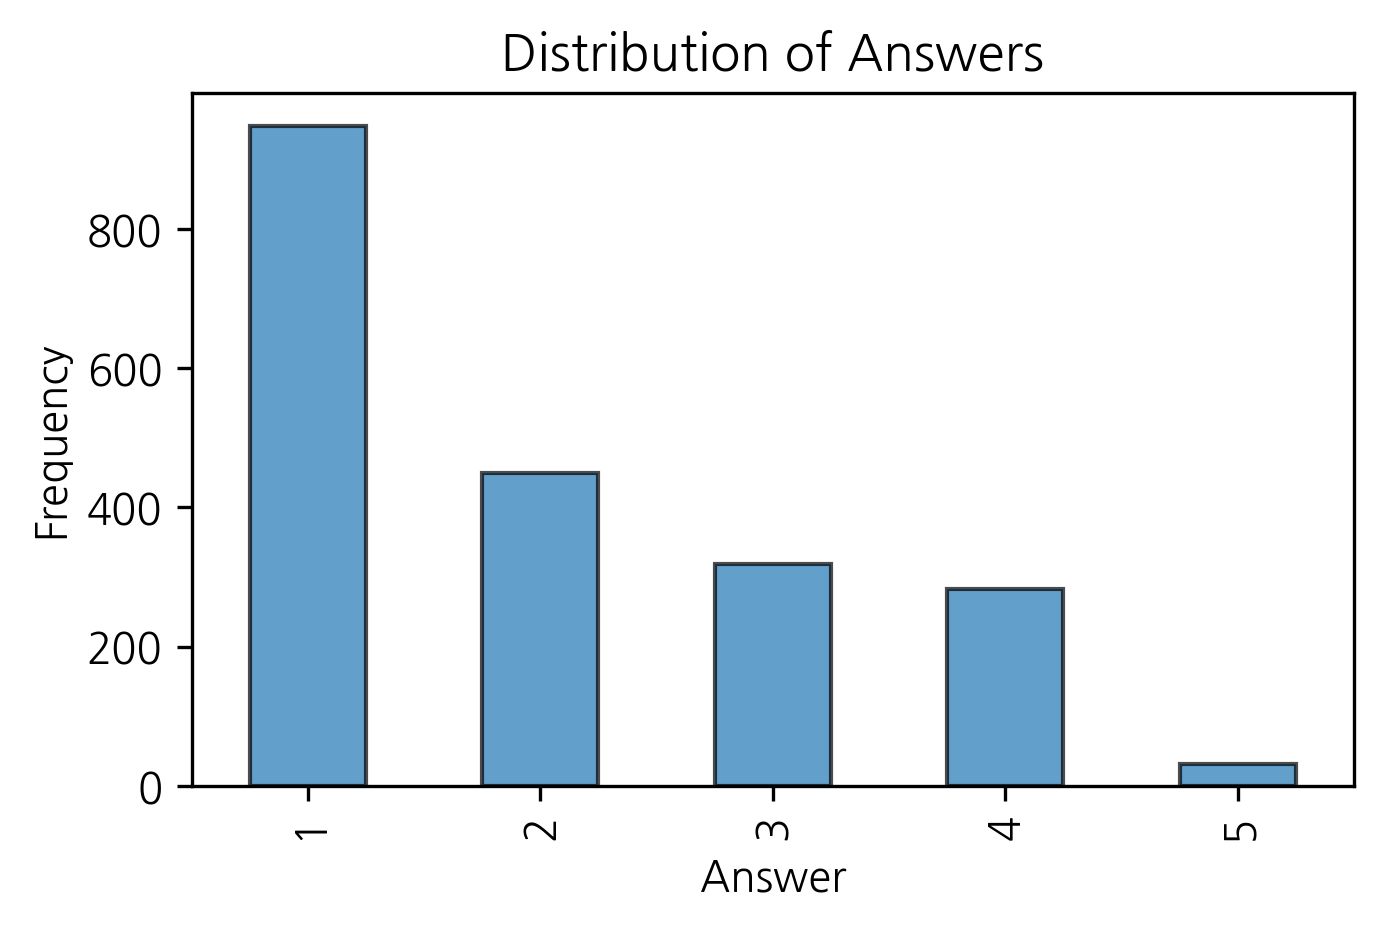

In [10]:
plt.figure(figsize=(5, 3))
df['answer'].value_counts().plot(kind='bar', edgecolor='black', alpha=0.7)
plt.title('Distribution of Answers')
plt.xlabel('Answer')
plt.ylabel('Frequency')
plt.show()

### Question Length Distribution

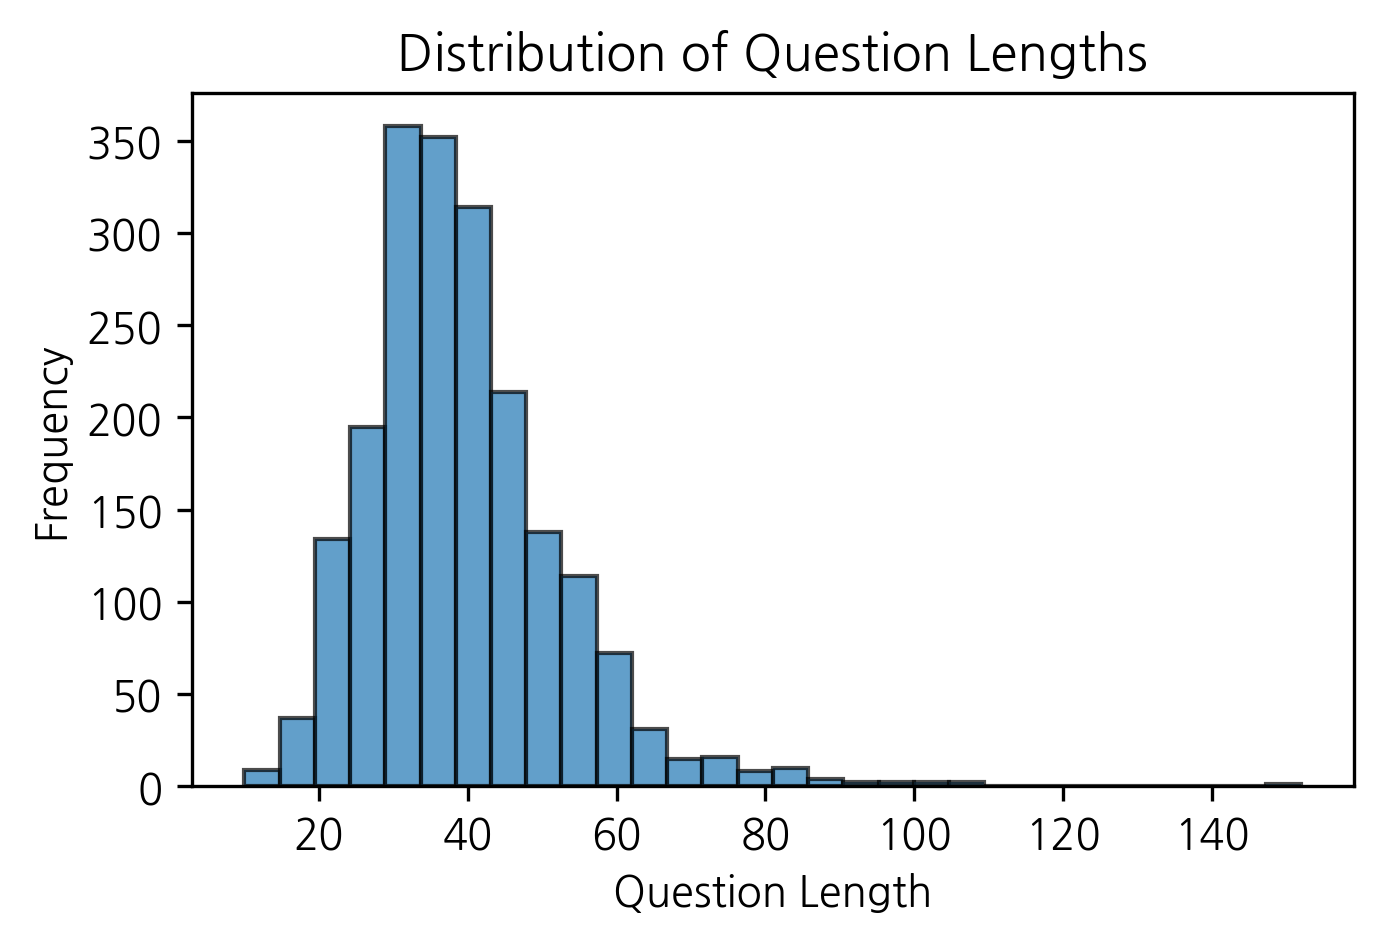

In [11]:
plt.figure(figsize=(5, 3))
plt.hist(df['question_length'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Question Lengths')
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.show()

## Feature Engineering using TF-IDF


### Initialize TF-IDF Vectorizer

In [13]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

### Fit and transform the text data

In [14]:
tfidf_matrix = tfidf_vectorizer.fit_transform(df['full_question'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

### Display the TF-IDF features

In [15]:
print("\nTF-IDF Features:")
display(tfidf_df.head(20))


TF-IDF Features:


11월  12월  1450  1450년에서  1750  1750년  17세기  19세기  1분기  1위를  2008년  2010년  \
0   0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
1   0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
2   0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
3   0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
4   0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
5   0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
6   0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
7   0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
8   0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
9   0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
10  0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
11  0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
12  0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
13  0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
14  0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
15  0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
16  0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
17  0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
18  0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
19  0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   

    2013년  2014  2014년  2014년도  2015학년도  2019  2019년  2020  2020년  20세기  2분기  \
0     0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
1     0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
2     0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
3     0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
4     0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
5     0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
6     0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
7     0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
8     0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
9     0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
10    0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
11    0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
12    0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
13    0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
14    0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
15    0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
16    0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
17    0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
18    0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
19    0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   

    2에서  3분기   5년   5월  600  600년에서   7월  ceo가   eu  fed  gdp   of   가격  가격과  \
0   0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5   0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6   0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7 

In [16]:
# Extract the top 20 most frequent keywords from the TF-IDF matrix
sum_words = tfidf_matrix.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in tfidf_vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# Display the top 20 keywords
top_keywords = words_freq[:20]
print("Top 20 Keywords:")
for word, freq in top_keywords:
    print(f"{word}: {freq}")

Top 20 Keywords:
무엇인가: 169.2715121961307
것은: 85.42871606066592
다음: 84.51883346342377
가장: 75.52901248663046
이유는: 69.88388833400661
무엇입니까: 57.411502654216825
어떤: 51.05304485715979
대한: 49.8825516441129
이름은: 48.35630819994585
주된: 46.65668032886526
얼마인가: 43.360552132662896
있는: 38.59035626136147
주요: 34.82835976886807
옳은: 32.825286686414906
목적은: 27.667645344690545
어디인가: 27.49125625641956
언제인가: 26.762211087609142
설명으로: 24.159430000465132
누구인가: 24.139237804022965
최근: 19.510878358415738
